# 3.4 Integrated Gradients

## Tensorflow Walkthrough

### 1. Import Dependencies

In [1]:
import os

from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.ops import nn_ops, gen_nn_ops
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from models.models_3_4 import MNIST_CNN

%matplotlib inline

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

images = mnist.train.images
labels = mnist.train.labels

logdir = './tf_logs/3_4_IG/'
ckptdir = logdir + 'model'

if not os.path.exists(logdir):
    os.mkdir(logdir)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### 2. Building Graph

In [2]:
with tf.name_scope('Classifier'):

    # Initialize neural network
    DNN = MNIST_CNN('CNN')

    # Setup training process
    X = tf.placeholder(tf.float32, [None, 784], name='X')
    Y = tf.placeholder(tf.float32, [None, 10], name='Y')

    activations, logits = DNN(X)
    
    tf.add_to_collection('IG', X)
    tf.add_to_collection('IG', logits)
    
    for activation in activations:
        tf.add_to_collection('IG', activation)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

    optimizer = tf.train.AdamOptimizer().minimize(cost, var_list=DNN.vars)

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

cost_summary = tf.summary.scalar('Cost', cost)
accuray_summary = tf.summary.scalar('Accuracy', accuracy)
summary = tf.summary.merge_all()

### 3. Training Network

In [3]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

# Hyper parameters
training_epochs = 15
batch_size = 100

for epoch in range(training_epochs):
    total_batch = int(mnist.train.num_examples / batch_size)
    avg_cost = 0
    avg_acc = 0
    
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        
        # zero-center the images
        mean = np.mean(batch_xs, axis=0, keepdims=True)
        batch_xs = batch_xs - mean
        
        _, c, a, summary_str = sess.run([optimizer, cost, accuracy, summary], feed_dict={X: batch_xs, Y: batch_ys})
        avg_cost += c / total_batch
        avg_acc += a / total_batch
        
        file_writer.add_summary(summary_str, epoch * total_batch + i)

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost), 'accuracy =', '{:.9f}'.format(avg_acc))
    
    saver.save(sess, ckptdir)

print('Accuracy:', sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))

sess.close()

Epoch: 0001 cost = 0.163972841 accuracy = 0.948563643
Epoch: 0002 cost = 0.042885760 accuracy = 0.986509101
Epoch: 0003 cost = 0.028830733 accuracy = 0.991109099
Epoch: 0004 cost = 0.023671029 accuracy = 0.992236371
Epoch: 0005 cost = 0.017320657 accuracy = 0.994254551
Epoch: 0006 cost = 0.013550124 accuracy = 0.995672731
Epoch: 0007 cost = 0.013328977 accuracy = 0.995200005
Epoch: 0008 cost = 0.008910857 accuracy = 0.997163639
Epoch: 0009 cost = 0.010496597 accuracy = 0.996472731
Epoch: 0010 cost = 0.007867829 accuracy = 0.997454548
Epoch: 0011 cost = 0.007225713 accuracy = 0.997636366
Epoch: 0012 cost = 0.008216114 accuracy = 0.997109094
Epoch: 0013 cost = 0.006957658 accuracy = 0.997600002
Epoch: 0014 cost = 0.004809637 accuracy = 0.997981820
Epoch: 0015 cost = 0.005449639 accuracy = 0.998109093
Accuracy: 0.9801


### 4. Restoring Graph

In [4]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

new_saver = tf.train.import_meta_graph(ckptdir + '.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(logdir))

activations = tf.get_collection('IG')
X = activations[0]
output = activations[-1]

sample_imgs = [images[np.argmax(labels, axis=1) == i][4] for i in range(10)]

INFO:tensorflow:Restoring parameters from ./tf_logs/3_4_IG/model


### 5. Displaying Images

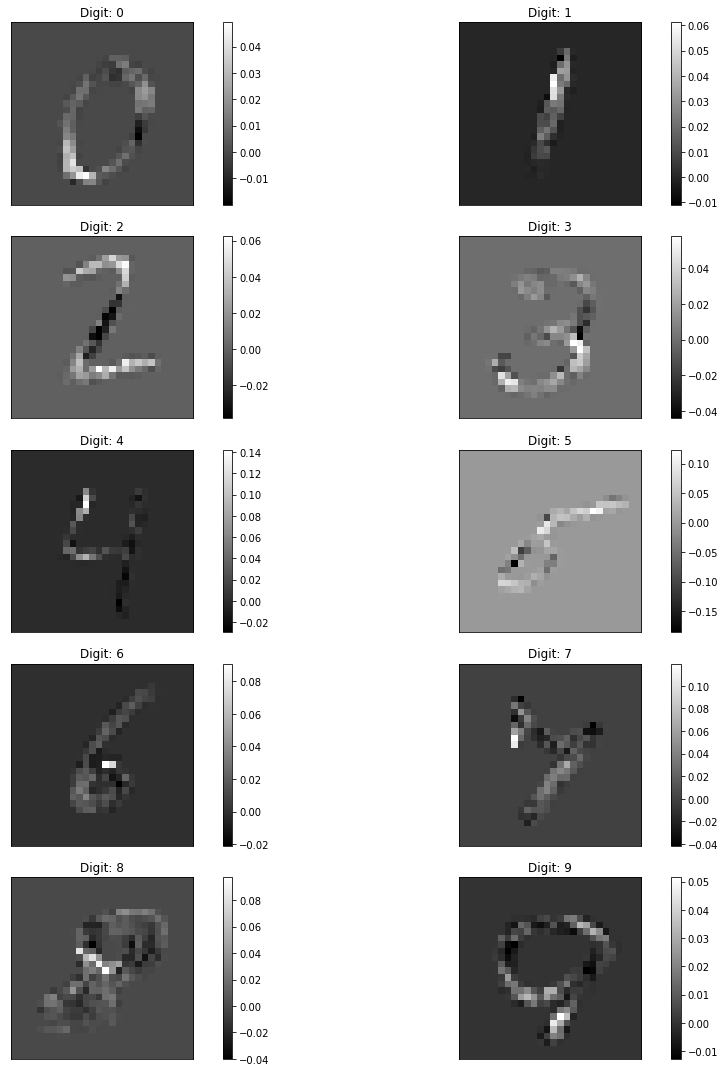

In [5]:
steps = 100
results = []

for j in range(10):
    gradient = tf.gradients(output[:,j], X)[0]
    counterfs = [sample_imgs[j] * i / steps for i in range(steps + 1)]
    grads = sess.run(gradient, feed_dict={X: counterfs})
    integrad = np.zeros_like(sample_imgs[j])

    for i in range(steps):
        integrad += grads[i + 1] * (counterfs[i + 1] - counterfs[i])
    
    results.append(integrad)

plt.figure(figsize=(15,15))
for i in range(5):
    plt.subplot(5, 2, 2 * i + 1)
    plt.imshow(np.reshape(results[2 * i], [28, 28]), cmap='gray', interpolation='none')
    plt.title('Digit: {}'.format(2 * i))
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    
    plt.subplot(5, 2, 2 * i + 2)
    plt.imshow(np.reshape(results[2 * i + 1], [28, 28]), cmap='gray', interpolation='none')
    plt.title('Digit: {}'.format(2 * i + 1))
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()

plt.tight_layout()